<a href="https://colab.research.google.com/github/SamigullinRT/HPC/blob/main/Bilateral_Filtering/Samigullin_6133_bilateral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Самигуллин Равиль гр6133
Для выполнения я подключил google диск

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Установка pycuda

In [62]:
!pip install pycuda

In [52]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Xeon(R) CPU @ 2.30GHz'

In [53]:
!nvidia-smi

Sat Nov  4 02:31:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |    103MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [54]:
from pycuda import driver, compiler, gpuarray
import pycuda.autoinit
import numpy as np
import cv2
import time
from google.colab.patches import cv2_imshow
from pycuda.compiler import SourceModule

Создание фильтра на cpu

In [55]:
#Входные данные: изображение,
#sigma_d - стандартное отклонение для пространственного фильтра,
#sigma_r - стандартное отклонение для радиометрического фильтра,
#Window size - размер окна фильтра
def calculate_pixel(image, i, j, sigma_d, sigma_r, window_size):
    s = 0
    c = 0
    half_window = window_size // 2

    for k in range(i - half_window, i + half_window + 1):
        for l in range(j - half_window, j + half_window + 1):
            if k >= 0 and k < image.shape[0] and l >= 0 and l < image.shape[1]:
                g_coef_depend = np.exp(-((k - i) ** 2 + (l - j) ** 2) / sigma_d ** 2)
                i1 = image[k, l]
                i2 = image[i, j]
                r_new_intensity = np.exp(-((i1 - i2) ** 2) / sigma_r ** 2)
                c += g_coef_depend * r_new_intensity
                s += g_coef_depend * r_new_intensity * image[k, l]

    result = s / c
    return result

def calculate_bilateral_CPU(image, sigma_d, sigma_r, window_size):
    new_image = np.zeros(image.shape)
    width = image.shape[0]
    height = image.shape[1]
    half_window = window_size // 2
    for i in range(half_window, width - half_window):
        for j in range(half_window, height - half_window):
            new_image[i, j] = calculate_pixel(image, i, j, sigma_d, sigma_r, window_size)

    return new_image

In [56]:
#Входные данные: изображение,
#sigma_d - стандартное отклонение для пространственного фильтра,
#sigma_r - стандартное отклонение для радиометрического фильтра,
#Window size - размер окна фильтра
def bilateral_filter(image, sigma_d, sigma_r, window_size):
    M, N = image.shape
    gpu_result = np.zeros((M, N), dtype=np.uint32)
    block = (32, 1, 1)
    grid = (int(np.ceil(M/block[0])), int(np.ceil(N/block[1])))

    calculate_bilateral_GPU = SourceModule("""
    texture<unsigned int, 2, cudaReadModeElementType> tex;

    __global__ void bil_gpu(unsigned int * __restrict__ d_result, const int M, const int N, const int window_size, const float sigma_d, const float sigma_r)
    {
        const int i = threadIdx.x + blockDim.x * blockIdx.x;
        const int j = threadIdx.y + blockDim.y * blockIdx.y;

        if ((i<M)&&(j<N)) {
            float s = 0;
            float c = 0;
            int half_window = window_size / 2;

            for (int l = i - half_window; l <= i + half_window; l++){
                for (int k = j - half_window; k <= j + half_window; k++){
                    if (l >= 0 && l < M && k >= 0 && k < N) {
                        float firstImg = tex2D(tex, k, l) / 255;
                        float secondImg = tex2D(tex, i, j) / 255;
                        float g = exp(-(pow(k - i, 2) + pow(l - j, 2)) / pow(sigma_d, 2));
                        float r = exp(-pow((firstImg - secondImg) * 255, 2) / pow(sigma_r, 2));
                        c += g * r;
                        s += g * r * tex2D(tex, k, l);
                    }
                }
            }

            d_result[i * N + j] = s / c;
        }
    }
    """)

    bil_gpu = calculate_bilateral_GPU.get_function("bil_gpu")

    tex = calculate_bilateral_GPU.get_texref("tex")
    tex.set_filter_mode(driver.filter_mode.LINEAR)
    tex.set_address_mode(0, driver.address_mode.MIRROR)
    tex.set_address_mode(1, driver.address_mode.MIRROR)
    driver.matrix_to_texref(image.astype(np.uint32), tex, order="C")

    bil_gpu(driver.Out(gpu_result), np.int32(M), np.int32(N), np.int32(window_size), np.float32(sigma_d), np.float32(sigma_r), block=block, grid=grid, texrefs=[tex])

    return gpu_result

In [57]:
#загрузим изображения
IMG0 = '/content/drive/MyDrive/bmp_images/1280x720.bmp'
image0 = cv2.imread(IMG0, cv2.IMREAD_GRAYSCALE)
cv2.imwrite('/content/drive/MyDrive/bmp_images/1280x720.bmp', image0)

IMG1 = '/content/drive/MyDrive/bmp_images/1920x1280.bmp'
image1 = cv2.imread(IMG1, cv2.IMREAD_GRAYSCALE)
cv2.imwrite('/content/drive/MyDrive/bmp_images/1920x1280.bmp', image1)

IMG2 = '/content/drive/MyDrive/bmp_images/4096x2560.bmp'
image2 = cv2.imread(IMG2, cv2.IMREAD_GRAYSCALE)
cv2.imwrite('/content/drive/MyDrive/bmp_images/4096x2560.bmp', image2)

IMG3 = '/content/drive/MyDrive/bmp_images/640x427.bmp'
image3 = cv2.imread(IMG3, cv2.IMREAD_GRAYSCALE)
cv2.imwrite('/content/drive/MyDrive/bmp_images/640x427.bmp', image3)

#зададим параметры
sigma_d = 300
sigma_r = 300
window_size = 4

# Эксперименты

Оригинал


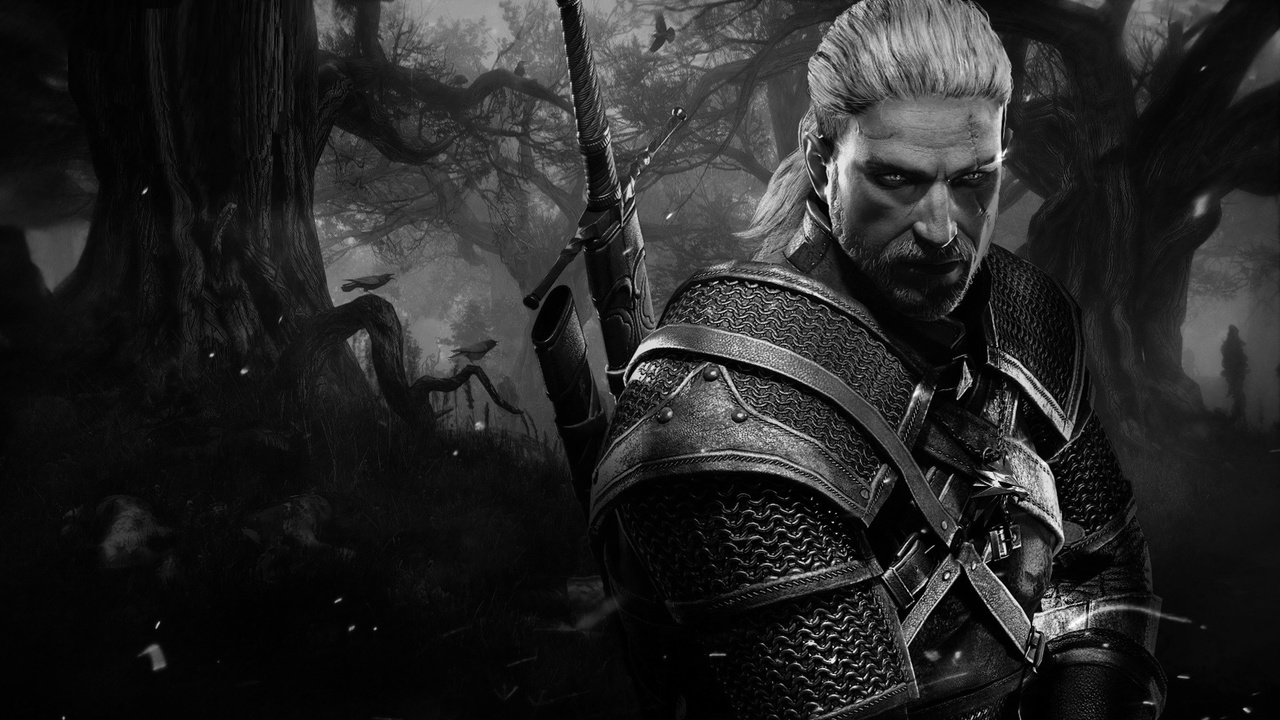

In [58]:
print("Оригинал")
cv2_imshow(image0)

Bilateral filtering on CPU

<ipython-input-55-587310b632e1>:16: RuntimeWarning: overflow encountered in ubyte_scalars
  r_new_intensity = np.exp(-((i1 - i2) ** 2) / sigma_r ** 2)


Изображение CPU


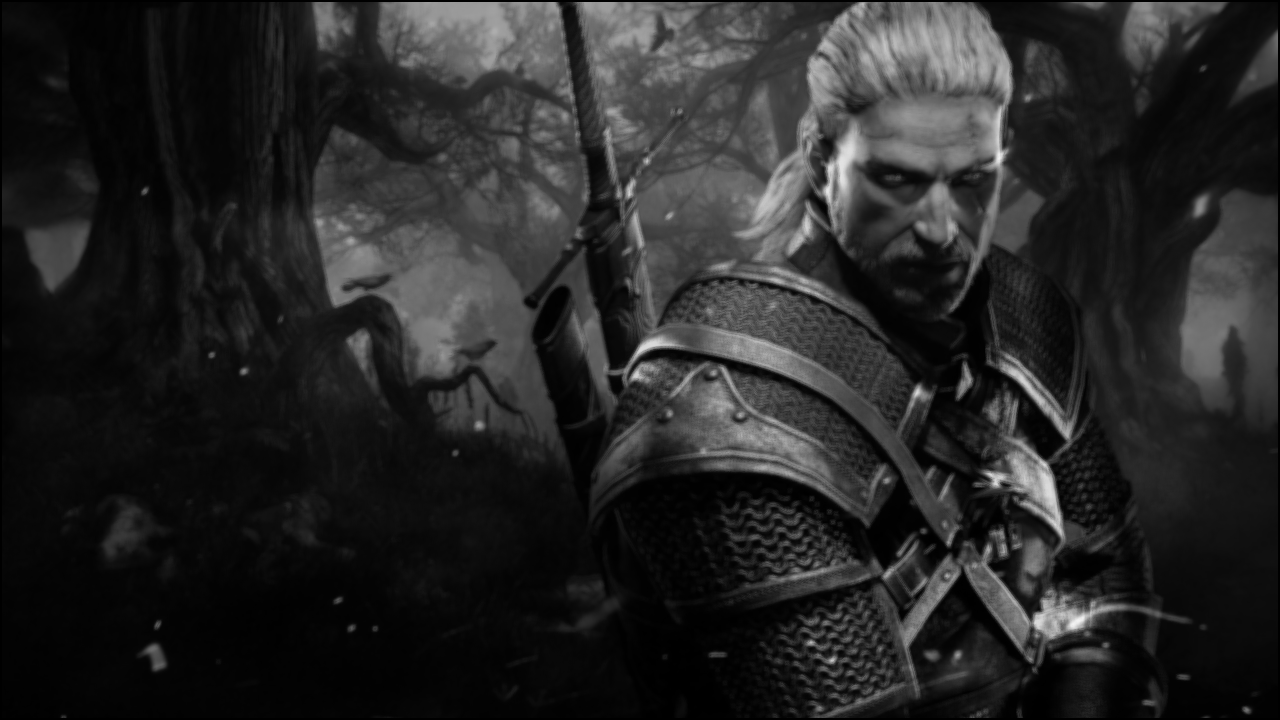

Время на CPU:  171.18907


In [59]:
cpu_start = time.time()
cpu_result = calculate_bilateral_CPU(image0, sigma_d, sigma_r, window_size)
cpu_time = time.time() - cpu_start
cv2.imwrite('/content/drive/MyDrive/bmp_images/4096x2560-cpu.bmp', cpu_result)
print("Изображение CPU")
cv2_imshow(cpu_result)
print('Время на CPU: ', round(cpu_time,5))

Bilateral filtering on GPU

Изображение GPU


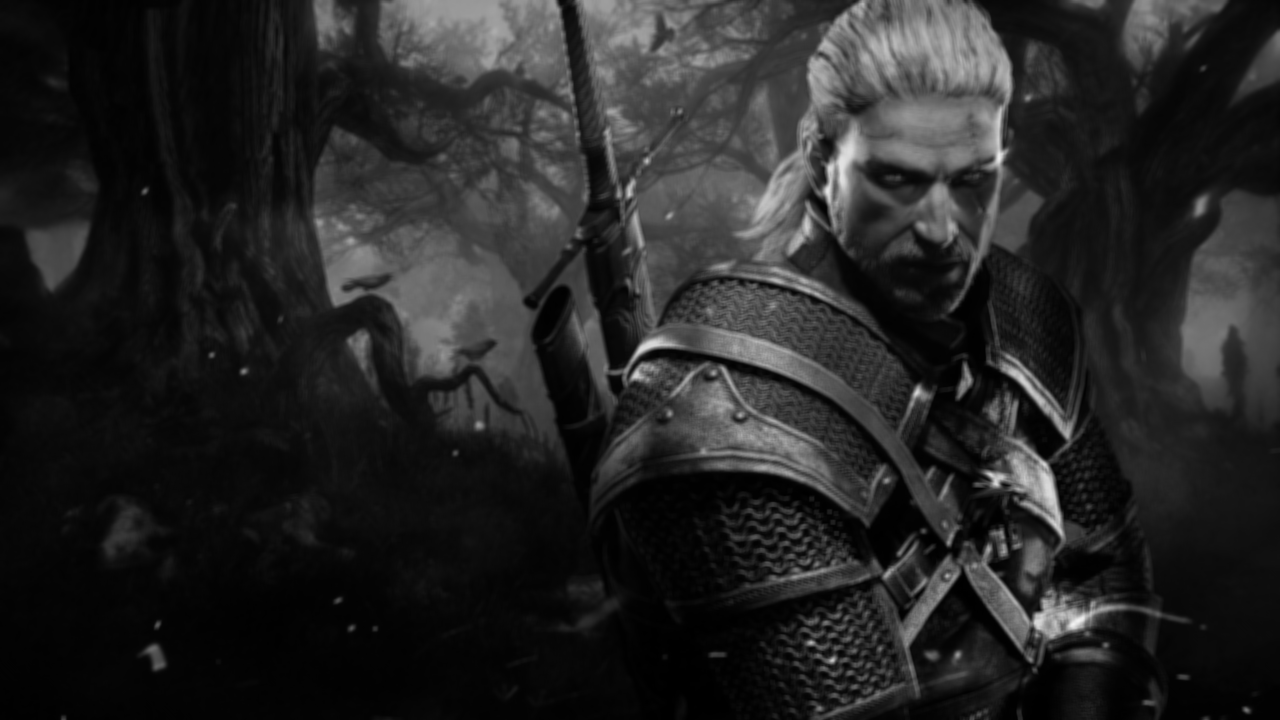

Время на GPU:  0.26416


In [60]:
gpu_start = time.time()
gpu_result = bilateral_filter(image0, sigma_d, sigma_r, window_size)
gpu_time = time.time() - gpu_start
print("Изображение GPU")
cv2.imwrite('/content/drive/MyDrive/bmp_images/4096x2560-gpu.bmp', gpu_result.astype(np.uint8))
cv2_imshow(gpu_result)
print('Время на GPU: ', round(gpu_time,5))

In [61]:
print("Ускорение: ",cpu_time/gpu_time)

Ускорение:  648.0602607877063
